In [1]:
import ndsplines
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

# NDSPlines extrapolation wierdness

In [2]:
import sys 
sys.path.append('../../tests/jax')
import utils

In [3]:
# s1 = utils.make_random_equidistant_spline(1,3)
s1 = utils.make_random_equidistant_spline_2(1,3)
s2 = utils.make_random_equidistant_spline(1,3, extrapolate=True)
print(s1.knots)
# print(s2.knots)

print(s1.coefficients)
# print(s2.coefficients)

[array([0.        , 0.        , 0.        , 0.        , 0.08333333,
       0.16666667, 0.25      , 0.33333333, 0.41666667, 0.5       ,
       0.58333333, 0.66666667, 0.75      , 0.83333333, 0.91666667,
       1.        , 1.        , 1.        , 1.        ])]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.71295532]
 [0.42847093]
 [0.69088486]
 [0.71915031]
 [0.49111893]
 [0.78002776]
 [0.41092437]
 [0.5796943 ]
 [0.13995076]
 [0.        ]
 [0.        ]
 [0.        ]]


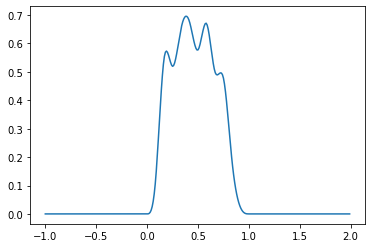

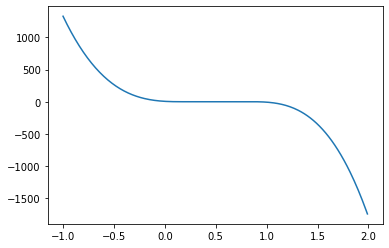

In [4]:
x = np.arange(-1,2,0.01)

plt.plot(x, s1(x))
plt.show()

plt.plot(x, s2(x))
plt.show()

# PPoly 1-D Demo

In [5]:
from uf3.jax.ppoly import *

In [6]:
s1 = utils.make_random_equidistant_spline_2(1,3)
ppoly = PPoly.from_NDSpline(s1)

2022-04-20 22:13:59.399832: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [7]:
print(ppoly.equidistant)

True


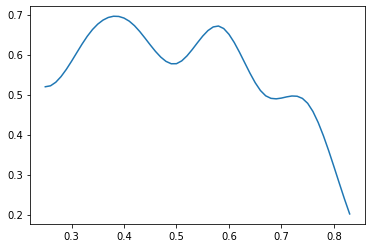

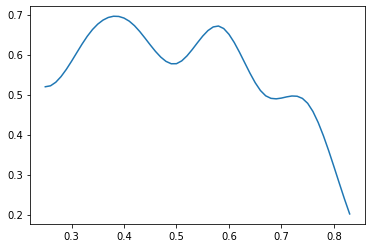

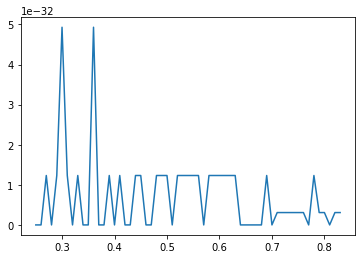

In [8]:
k = ppoly.x[0]
x = np.arange(k[3],k[-3],0.01)

plt.plot(x, s1(x))
plt.show()

plt.plot(x, ppoly(x))
plt.show()

plt.plot(x, (s1(x) - ppoly(x))**2)
plt.show()

In [9]:
print(ppoly.x)

#id = (slice(None),) + tuple([2,3])
#print(ppoly.c[id])
print(ppoly.c[:,2])

[DeviceArray([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
             0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
             0.83333333, 0.91666667, 1.        ], dtype=float64)]
[444.76935495 -71.81565947   2.57082556   0.54671537]


In [10]:
import uf3.jax.fun_test as ft

In [11]:
enum = coefficient_enumeration((3,))
order = enumeration_to_derivative_order(enum, 1)
y = ft.single_poly_eval(ppoly.c[:,9],0.51,np.asarray([0.5]),enum)

print(y)
print(s1(0.51))
res = ppoly(0.51).flatten()
print(res)
print(math.isclose(res, s1(0.51)))
print(res[0] - s1(0.51))

[0.45789727]
0.58431186458464
[0.58431186]
True
0.0


# PPoly evaluate tests

In [12]:
xp = jnp.asarray([[0.51]])

base = ppoly.t[0]
deltas = ppoly.t[1] - ppoly.t[0]

idx = (xp - base) // deltas
idx = idx.astype(jnp.int32)
n, d = xp.shape

print(idx)
print(ppoly.t[idx])
print(ppoly.t[idx, jnp.tile(jnp.arange(d, dtype=jnp.int32), (n, 1))])
print(xp - ppoly.t[idx, jnp.tile(jnp.arange(d, dtype=jnp.int32), (n, 1))])

[[6]]
[[[0.5]]]
[[0.5]]
[[0.01]]


In [13]:
x = xp - ppoly.t[idx, jnp.tile(jnp.arange(d, dtype=jnp.int32), (n, 1))]
print(x)

[[0.01]]


In [14]:
id = tuple(jnp.transpose(idx))
c = ppoly.c[:,id]

#print(ppoly.c)
print(id)
print(c)

(DeviceArray([6], dtype=int32),)
[[[-338.38629779]]

 [[  37.21969477]]

 [[   0.36526471]]

 [[   0.57727563]]]


In [15]:
result = jnp.zeros(len(x))
i = 0
for p in ppoly.enum:
    tmp = jnp.zeros_like(result)
    for q in p:
        tmp = (tmp + c[i, :]) * jnp.prod(x[:, q], axis=1)
        i += 1
    result += tmp

print(result)
print(c[0,:])

[[0.58431186]]
[[-338.38629779]]


## 2-D evaluation

In [16]:
s2 = utils.make_random_equidistant_spline(2,3)
p2 = PPoly.from_NDSpline(s2)
x = [0.3,0.6]

In [26]:
p2.c.shape

(16, 18, 17)

In [17]:
s2(x)

array([0.55670911])

In [18]:
p2(x)

DeviceArray([0.55670911], dtype=float64)

In [19]:
f = p2._evaluate_equidistant()
f(jnp.asarray([x]))

DeviceArray([0.55670911], dtype=float64)

## 3-D evaluation

In [21]:
s3 = utils.make_random_equidistant_spline(3,3)
p3 = PPoly.from_NDSpline(s3, naive=True)
x = [0.3,0.6, 0.5]

In [25]:
p3.c.shape

(64, 18, 17, 18)

In [39]:
x = np.random.rand(1000000,3)

In [42]:
s3(x)

array([0.30787792, 0.38992939, 0.34640269, ..., 0.44588921, 0.53600683,
       0.44549584])

In [43]:
p3(x)

DeviceArray([0.30787792, 0.40761206, 0.36459321, ..., 0.46556414,
             0.71444966, 0.59145899], dtype=float64)